<a href="https://colab.research.google.com/github/kundajelab/adar_editing/blob/master/xgboost_with_shap/NEIL1_XGBOOST_WITH_TREESHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

## Uncomment these lines if running as a google colab notebook: 
#!pip install numpy==1.15
#! git clone https://github.com/kundajelab/adar_editing
#import os
#os.chdir("adar_editing/xgboost_with_shap/")
#!pip install shap
#!pip install --upgrade xgboost
#!pip install cufflinks


In [2]:
%load_ext autoreload
%autoreload 2   

In [3]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


In [4]:
#helper utilities for model training and interpretation 
import shap
from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap


/users/annashch/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/users/annashch/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)



## Neil1 xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#1>Degenerate Dataset</a></li>
    <li><a href=#2>Degenerate Dataset: Feature Subsets</a></li>
    <li><a href=#3>Computational Dataset</a></li>
    <li><a href=#4>Computational Dataset Feature Subsets</a></li>
    <li><a href=#5>Exclude mut features</a></li>
 </ol>


## NEIL1 Degenerate features<a name='1'>
<a href=#outline>Home</a>

In [5]:
## Read in the data 
import pandas as pd 
data=pd.read_csv("../xin_feature_matrices/neil1_degenerate_computational.features.csv",header=0,sep=',',index_col=0)

In [6]:
data

editing_value  free_energy  sim_nor_score  num_mutations  mut_exist  \
rna_id                                                                        
DG0033         0.9145       -42.11         0.9854              1          1   
DG0039         0.8835       -43.32         0.9766              2          1   
DG0039         0.8835       -43.32         0.9766              2          1   
DG0040         0.8580       -39.73         0.9769              2          1   
DG0040         0.8580       -39.73         0.9769              2          1   
DG0041         0.8755       -43.84         0.9947              2          1   
DG0041         0.8755       -43.84         0.9947              2          1   
DG0043         0.8730       -39.42         0.9672              2          1   
DG0043         0.8730       -39.42         0.9672              2          1   
DG0046         0.8630       -43.77         0.9766              2          1   
DG0046         0.8630       -43.77         0.9766              2          1   
DG0047         0.8375       -38.67         0.9038              2          1   
DG0047         0.8375       -38.67         0.9038              2          1   
DG0049         0.7540       -43.25         0.9922              1          1   
DG0050         0.7395       -44.48         1.0000              1          1   
DG0051         0.7495       -39.47         0.9315              2          1   
DG0051         0.7495       -39.47         0.9315              2          1   
DG0052         0.6540       -44.19         1.0000              1          1   
DG0053         0.6875       -41.20         0.9818              2          1   
DG0053         0.6875       -41.20         0.9818              2          1   
DG0054         0.6865       -39.54         0.7529              2          1   
DG0054         0.6865       -39.54         0.7529              2          1   
DG0055         0.6855       -40.32         0.9859              1          1   
DG0056         0.6805       -42.96         0.9854              1          1   
DG0057         0.6985       -41.91         0.9914              1          1   
DG0058         0.6025       -43.41         1.0000              1          1   
DG0059         0.6850       -44.88         1.0000              1          1   
DG0060         0.6675       -42.39         0.9922              1          1   
DG0061         0.6690       -41.75         1.0000              1          1   
DG0062         0.6810       -45.40         0.9911              1          1   
...               ...          ...            ...            ...        ...   
DG0487         0.0000       -36.94         0.9617              5          1   
DG0488         0.0000       -36.53         0.9310              6          1   
DG0488         0.0000       -36.53         0.9310              6          1   
DG0488         0.0000       -36.53         0.9310              6          1   
DG0488         0.0000       -36.53         0.9310              6          1   
DG0488         0.0000       -36.53         0.9310              6          1   
DG0488         0.0000       -36.53         0.9310              6          1   
DG0490         0.0000       -38.52         0.9264              6          1   
DG0490         0.0000       -38.52         0.9264              6          1   
DG0490         0.0000       -38.52         0.9264              6          1   
DG0490         0.0000       -38.52         0.9264              6          1   
DG0490         0.0000       -38.52         0.9264              6          1   
DG0490         0.0000       -38.52         0.9264              6          1   
DG0493         0.0000       -36.17         0.9197              5          1   
DG0493         0.0000       -36.17         0.9197              5          1   
DG0493         0.0000       -36.17         0.9197              5          1   
DG0493         0.0000       -36.17         0.9197              5          1   
DG0493         0.0000       -36.17         0.9197         

In [7]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [8]:
## prepare data for training with xgboost 
data=format_for_xgboost(data)


(856, 207)


In [9]:
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data[~data['mut_pos'].isna()])
null_mut_pos=data[data['mut_pos'].isna()]
train_split=pd.concat((train_split,null_mut_pos),axis=0)

{44.0: 98, 45.0: 155, 46.0: 124, 48.0: 160, 49.0: 79, 50.0: 97, 51.0: 12, 52.0: 12, 53.0: 10, 54.0: 108}


In [10]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [11]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [12]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

d2_3prm_cp_bulge:G:U
d3_exist
mut_ref_struct:I
d2_3prm_cp_internal:G:U
u1_5prm_cp_internal
d2_3prm_cp_internal:A:U
mut_prev_struct:B
d2_5prm_cp_bulge:C:G
u3_3prm_cp_internal
u3_3prm_cp_bulge:U:A
mut_type:mismatch
d1_length_hairpin
mut_ref_nt:C
u2_length_internal_ecs
u1_5prm_cp_hairpin:C:G
site_5prm_cp_bulge:G:U
mut_exist
mut_ref_struct:S
u2_5prm_cp_internal
mut_pos
u1_length_internal_ecs
u3_5prm_cp_internal
u2_length_internal_es
mut_ref_nt:U
u1_exist
d1_5prm_cp_hairpin
mut_ref_nt:G
mut_type:wt
u3_length_internal_es
u3_length_internal_ecs
mut_next_struct:H
d2_5prm_cp_bulge:G:U
u1_3prm_cp_internal
u2_5prm_cp_bulge:G:U
mut_same_as_site
u2_5prm_cp_bulge:U:A
d3_5prm_cp_hairpin
u2_exist
mut_ref_nt:A
mut_site_dist
d2_3prm_cp_bulge:G:C
u2_3prm_cp_internal
d1_exist
d2_5prm_cp_hairpin
d2_length_hairpin
mut_nt:G
u1_length_internal_es
d3_length_hairpin
d2_exist
u2_5prm_cp_hairpin:U:G


In [13]:
#remove teh features that don't change across isoforms , or are null for all isoforms
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [14]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [15]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(495, 156)
(495,)
(98, 156)
(98,)
(167, 156)
(167,)


In [16]:
## format matrixes for xgboost 
import xgboost
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [17]:
## set model training parameters 
from __future__ import unicode_literals
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 

#Note: the last metric in your 'eval_metric' list will get optimized 
param['eval_metric'] = ['aucpr','auc','mae','map','rmse']

In [18]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [19]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-aucpr:0.522969	eval-auc:0.949179	eval-mae:0.335204	eval-map:1	eval-rmse:0.340022	train-aucpr:0.723263	train-auc:0.968416	train-mae:0.318309	train-map:1	train-rmse:0.327983
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-aucpr:0.493063	eval-auc:0.948216	eval-mae:0.236159	eval-map:1	eval-rmse:0.239243	train-aucpr:0.727773	train-auc:0.968704	train-mae:0.225158	train-map:1	train-rmse:0.232111
[2]	eval-aucpr:0.549958	eval-auc:0.950143	eval-mae:0.166746	eval-map:1	eval-rmse:0.169175	train-aucpr:0.729637	train-auc:0.968849	train-mae:0.160052	train-map:1	train-rmse:0.165453
[3]	eval-aucpr:0.532911	eval-auc:0.949859	eval-mae:0.118254	eval-map:1	eval-rmse:0.120843	train-aucpr:0.73038	train-auc:0.968998	train-mae:0.114178	train-map:1	train-rmse:0.118812
[4]	eval-aucpr:0.501005	eval-auc:0.948195	eval-mae:0.084366	eval-map:1	eval-rmse:0.088775	train-aucpr:0.733855	train-auc:0.969317	tr

[45]	eval-aucpr:0.555843	eval-auc:0.982108	eval-mae:0.006128	eval-map:1	eval-rmse:0.038423	train-aucpr:0.762391	train-auc:0.977976	train-mae:0.001225	train-map:1	train-rmse:0.00259
[46]	eval-aucpr:0.555866	eval-auc:0.982144	eval-mae:0.006117	eval-map:1	eval-rmse:0.038502	train-aucpr:0.762395	train-auc:0.977981	train-mae:0.00119	train-map:1	train-rmse:0.002529
[47]	eval-aucpr:0.556921	eval-auc:0.982225	eval-mae:0.006073	eval-map:1	eval-rmse:0.038431	train-aucpr:0.762406	train-auc:0.97799	train-mae:0.001152	train-map:1	train-rmse:0.002463
[48]	eval-aucpr:0.556923	eval-auc:0.982229	eval-mae:0.006033	eval-map:1	eval-rmse:0.038418	train-aucpr:0.762408	train-auc:0.977991	train-mae:0.001076	train-map:1	train-rmse:0.002376
[49]	eval-aucpr:0.556923	eval-auc:0.982229	eval-mae:0.006014	eval-map:1	eval-rmse:0.03842	train-aucpr:0.762413	train-auc:0.977996	train-mae:0.001023	train-map:1	train-rmse:0.002269
[50]	eval-aucpr:0.555874	eval-auc:0.982152	eval-mae:0.005996	eval-map:1	eval-rmse:0.038413	tra

In [20]:
# save to binary file for faster loading
bst.save_model('neil1.degenerate.model')
# save model to text file 
bst.dump_model('neil1.degenerate.raw.txt')


In [21]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [22]:
test_pred.shape

(167,)

In [23]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals = test_y - test_pred

y_test_mean = np.mean(test_pred)
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y-y_test_mean)*(test_y-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.08984582
7.792358947383999
0.14528890918159407
The R-square of the test data is  0.981 



In [24]:
## Get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred,
                                   positive_thresh=0.2)

Train
	Spearman corr : SpearmanrResult(correlation=0.8523908407103716, pvalue=6.409884294723629e-141)
	Pearson corr : (0.9999543559678261, 0.0)
	MAE : 0.0009281260127743983
	MAPE : 0.04675893529686724
	RMSE : 0.0021478753869437024
	auPRC : 1.0
	auROC : 1.0
Eval
	Spearman corr : SpearmanrResult(correlation=0.7292812045623344, pvalue=1.6649193397240872e-17)
	Pearson corr : (0.968128715523943, 1.5892470005887382e-59)
	MAE : 0.005990427213738343
	MAPE : 0.08572297520751566
	RMSE : 0.0384430537542837
	auPRC : 1.0
	auROC : 1.0
Test
	Spearman corr : SpearmanrResult(correlation=0.8348495226687512, pvalue=1.2357539611793945e-44)
	Pearson corr : (0.9910258728458876, 3.909402385245225e-146)
	MAE : 0.004937601903241551
	MAPE : 0.07408012704524476
	RMSE : 0.029495651682125243
	auPRC : 0.9999999999999999
	auROC : 1.0


In [25]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.8523908407103716, pvalue=6.409884294723629e-141)
Eval:SpearmanrResult(correlation=0.7292812045623344, pvalue=1.6649193397240872e-17)
Test:SpearmanrResult(correlation=0.8348495226687512, pvalue=1.2357539611793945e-44)


Pearson correlation:
Train:(0.9999543559678261, 0.0)
Eval:(0.968128715523943, 1.5892470005887382e-59)
Test:(0.9910258728458876, 3.909402385245225e-146)


In [26]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0009281260127743983
MAE Eval:0.005990427213738343
MAE Test:0.004937601903241551


In [27]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:4.675893529686724%
MAPE Eval:8.572297520751567%
MAPE Test:7.408012704524476%


In [28]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0021478753869437024
RMSE Eval:0.0384430537542837
RMSE Test:0.029495651682125243


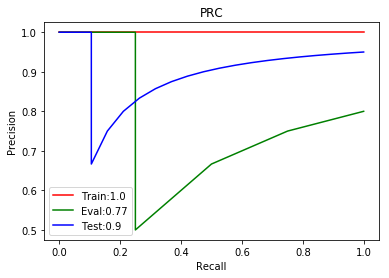

In [29]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.5,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.5,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.5,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

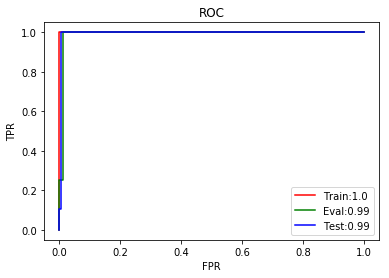

In [30]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.5,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.5,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.5,test_pred)

auroc_train=roc_auc_score(train_y>=0.5,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.5,eval_pred)
auroc_test=roc_auc_score(test_y>=0.5,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

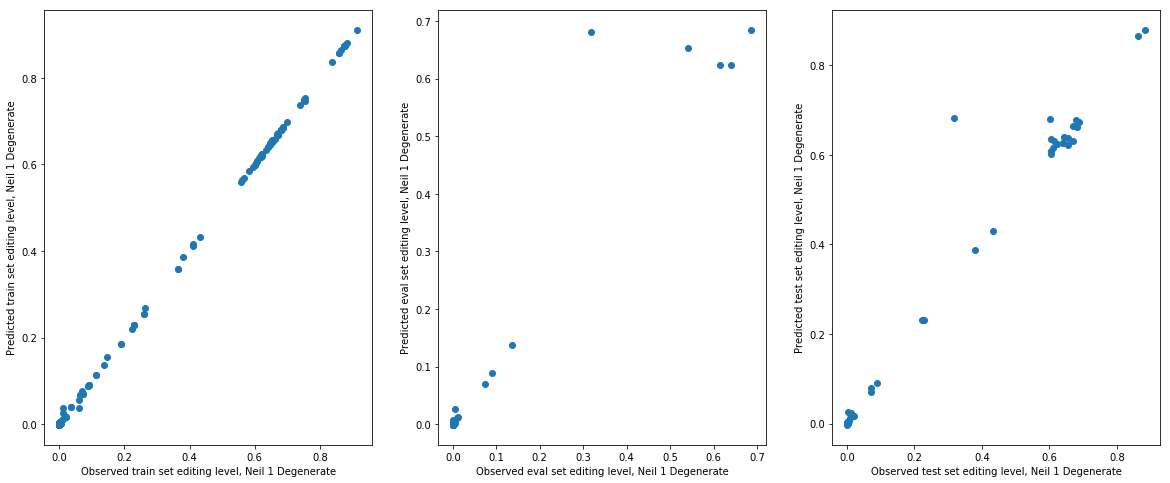

In [31]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

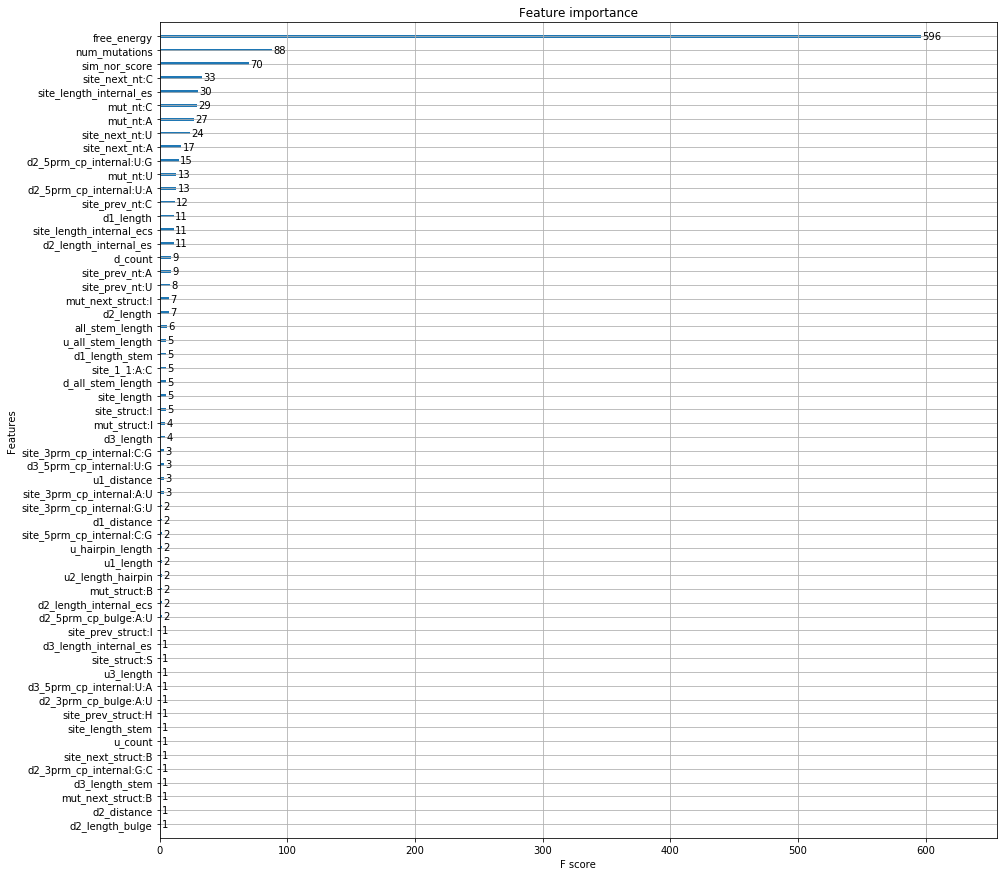

In [32]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

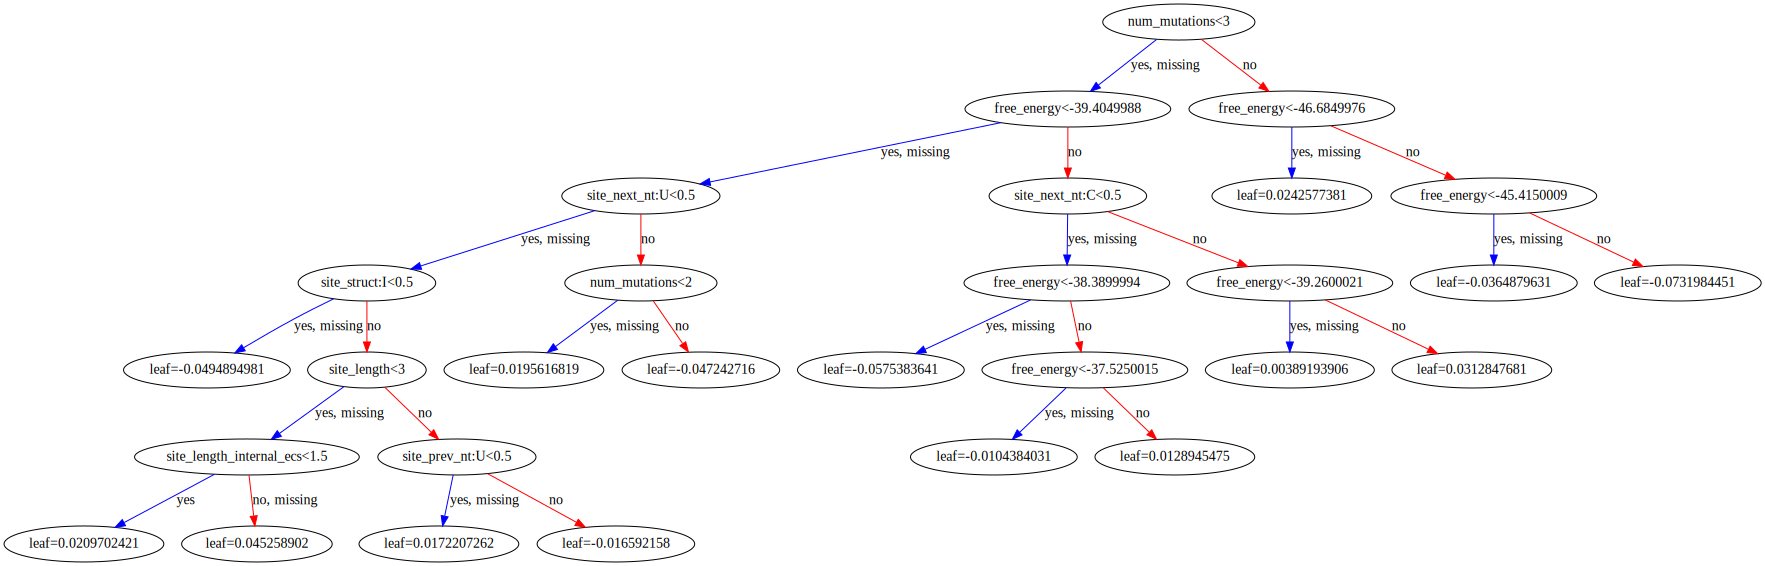

In [33]:
xgboost.to_graphviz(bst, num_trees=2)


In [34]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(167, 156)

In [35]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [36]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [37]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

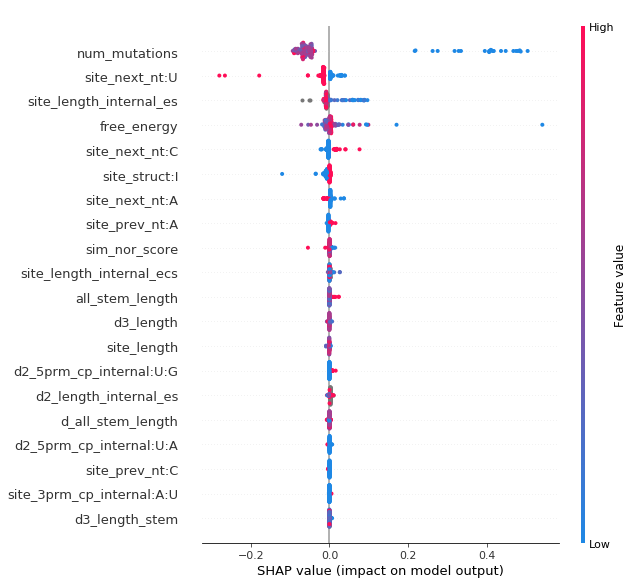

In [38]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


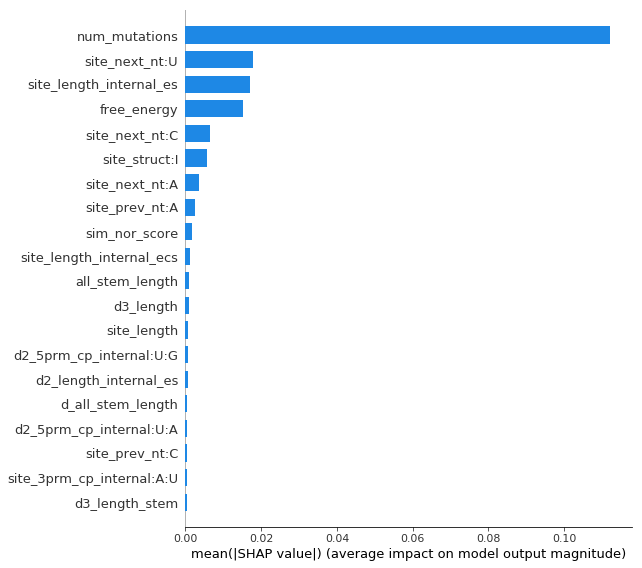

In [39]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [40]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(167, 156, 156)

In [41]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [42]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [43]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)


## Degenerate Dataset: Feature Subsets<a name='2'>
<a href=#outline>Home</a>

In [44]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


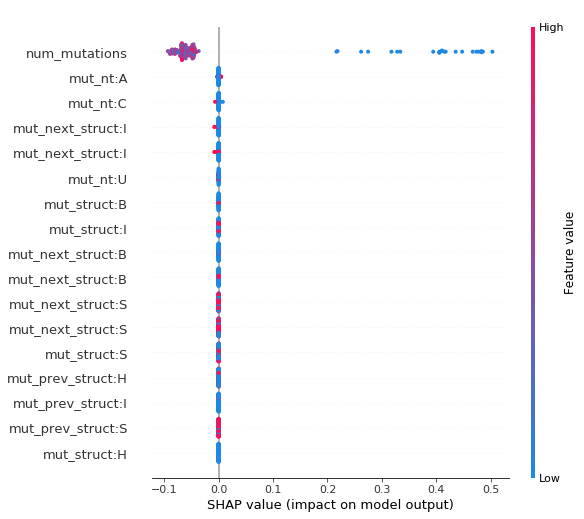

Contribution/Total:0.58161086
['site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


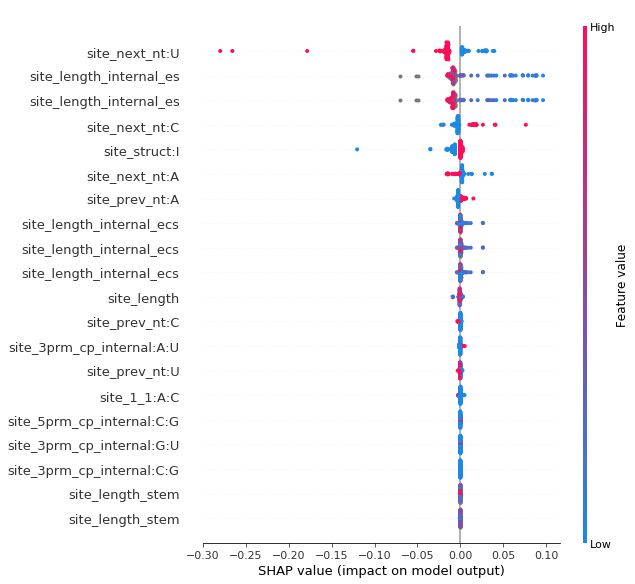

Contribution/Total:0.39264
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*']


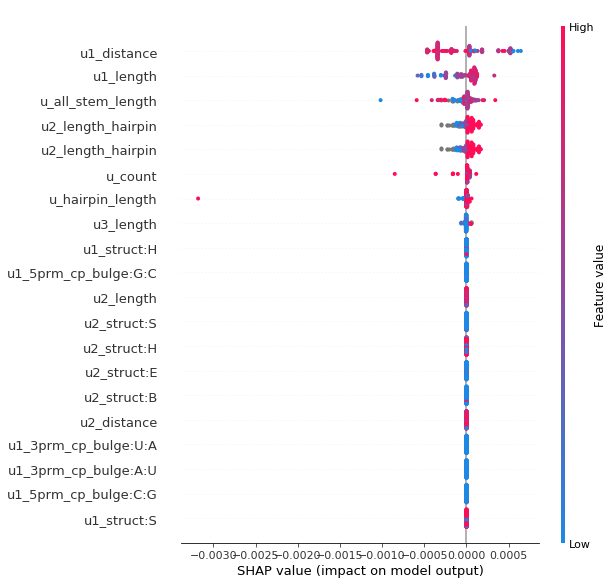

Contribution/Total:0.0035456412
['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_internal_es*', 'd2_length_internal_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_internal*', 'd2_3prm_cp_internal*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_internal_es*', 'd3_length_internal_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_internal*', 'd3_3prm_cp_internal*']


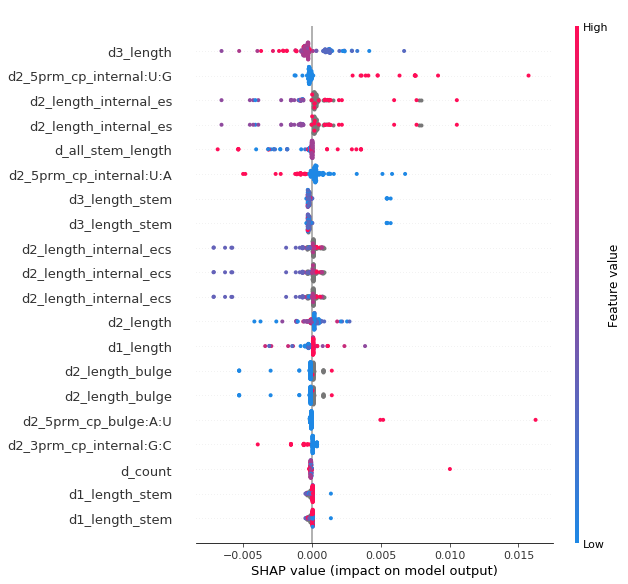

Contribution/Total:0.04376752
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*',

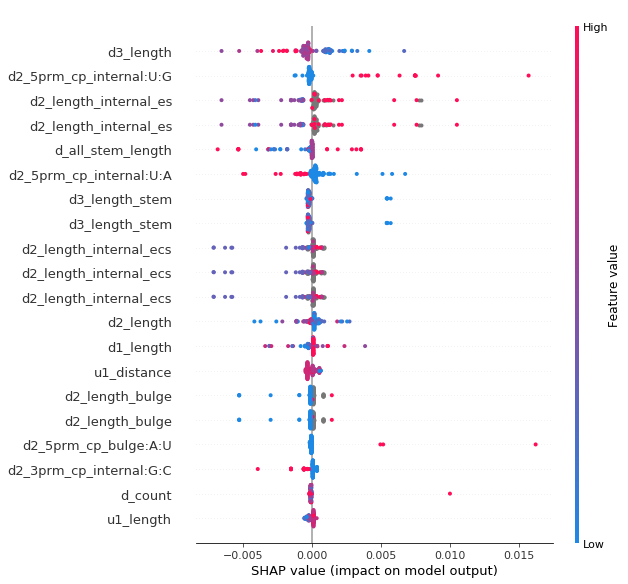

Contribution/Total:0.04731316
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


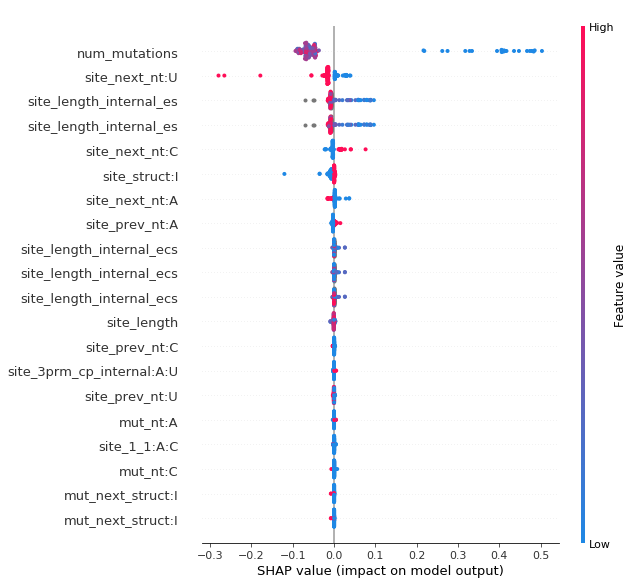

Contribution/Total:0.9742508
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_s

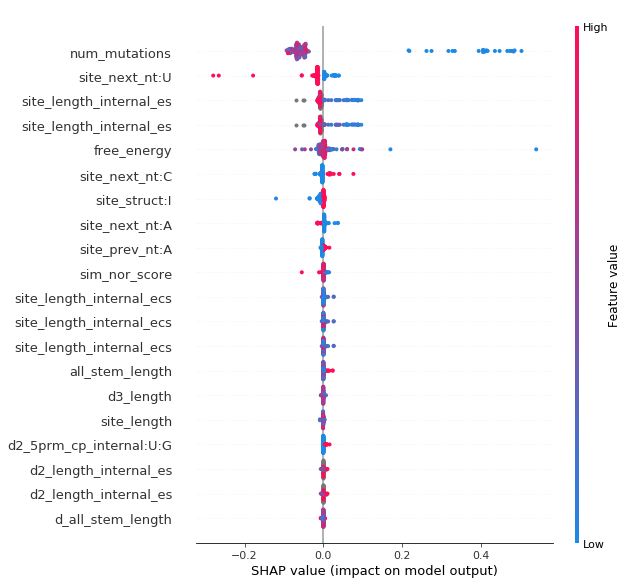

Contribution/Total:1.1124548
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 

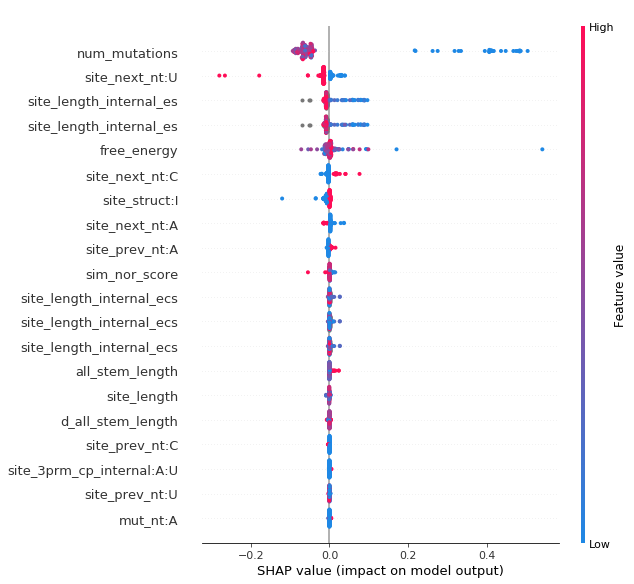

Contribution/Total:1.0722328
['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


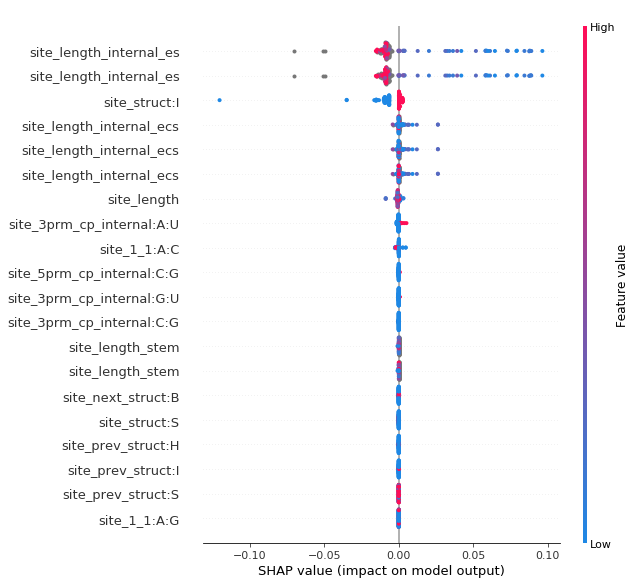

Contribution/Total:0.23132591
['site_prev_nt*', 'site_next_nt*']


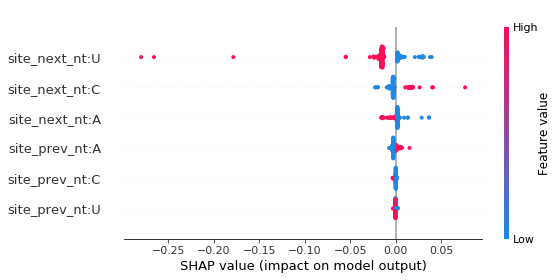

Contribution/Total:0.16131407
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


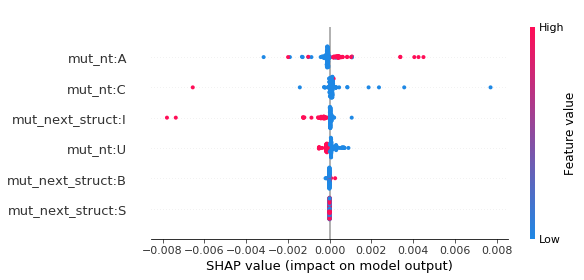

Contribution/Total:0.0052754516
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'site_prev_nt*', 'site_next_nt*']


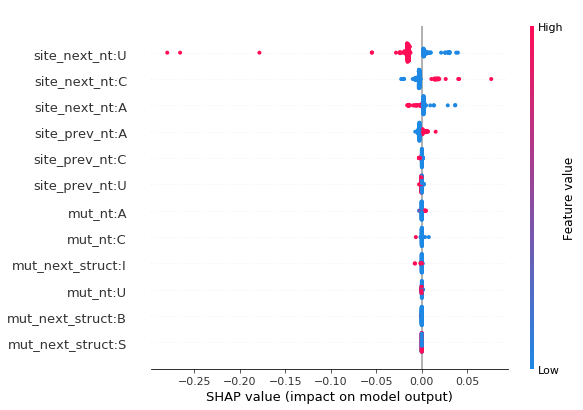

Contribution/Total:0.16658953
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_c

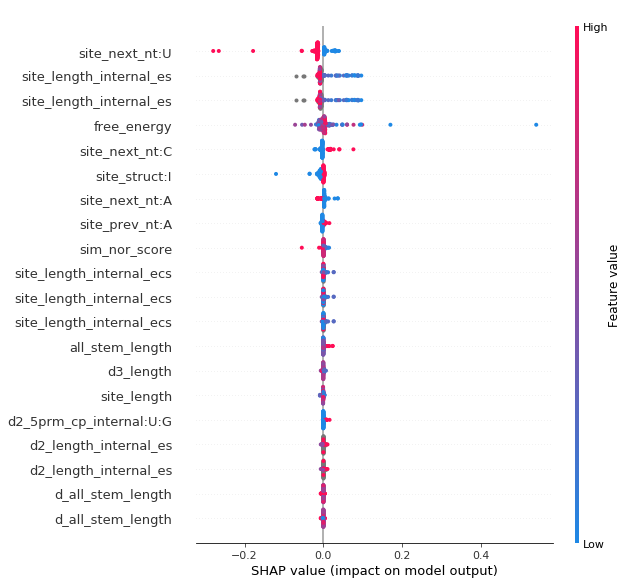

Contribution/Total:0.53438956
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*']


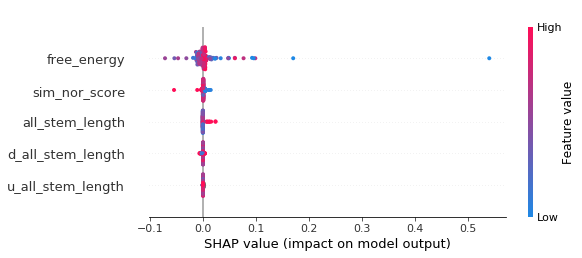

Contribution/Total:0.0944364


In [45]:
from feature_subsets import * 
for subset in [mut,site,u,d,u_d,mut_site,no_up,no_down,site_struct,site_seq,mut_seq,mut_seq_site,no_mut,overall_structure]: 
  print(subset)
  cur_features=filter_features(shap_values,subset)
  cur_feature_shap=shap_values[cur_features].values 
  cur_feature_test_X=test_X[cur_features]
  shap.summary_plot(cur_feature_shap, cur_feature_test_X)#,sort=False,max_display=50)
  print("Contribution/Total:"+str(shap_contribs_subgroup(shap_values,subset)))

## Neil1 Computational features <a name='3'>
<a href=#outline>Home</a>

In [46]:
import pandas as pd 
import xgboost
data=pd.read_csv("../xin_feature_matrices/neil1_computational.features.csv",header=0,sep=',',index_col=0)

In [47]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [48]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(428, 219)
{20.0: 3, 21.0: 3, 22.0: 3, 23.0: 4, 24.0: 3, 25.0: 4, 26.0: 3, 27.0: 4, 28.0: 4, 29.0: 4, 30.0: 3, 31.0: 4, 32.0: 4, 33.0: 4, 34.0: 4, 35.0: 4, 36.0: 4, 41.0: 20, 42.0: 21, 43.0: 18, 44.0: 18, 45.0: 20, 46.0: 19, 48.0: 20, 49.0: 21, 50.0: 21, 51.0: 20, 52.0: 20, 53.0: 21, 54.0: 19, 55.0: 21, 56.0: 20, 57.0: 15, 58.0: 15, 59.0: 16, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 21}


In [49]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [50]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [51]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

mut_struct:H
site_5prm_cp_internal:U:G
d2_3prm_cp_bulge:G:U
u3_5prm_cp_bulge:U:G
d3_exist
mut_ref_struct:I
d2_3prm_cp_internal:G:U
u1_5prm_cp_internal
u3_3prm_cp_bulge:G:C
u3_3prm_cp_internal
site_struct:M
site_5prm_cp_internal:A:U
d3_5prm_cp_internal:C:G
d1_length_hairpin
d3_length_hairpin
d1_length_bulge
u2_length_internal_ecs
d2_struct:H
site_5prm_cp_bulge:G:U
site_1_1:A:U
mut_ref_struct:B
u2_5prm_cp_internal
u1_length_internal_ecs
u3_5prm_cp_internal
d2_5prm_cp_internal:G:U
mut_ref_nt:U
d1_3prm_cp_internal:C:G
u1_exist
d1_5prm_cp_hairpin
u2_5prm_cp_hairpin:U:A
d1_5prm_cp_bulge
site_prev_struct:B
u3_length_internal_es
u3_length_internal_ecs
d2_5prm_cp_hairpin:C:G
d2_5prm_cp_bulge:G:U
d2_5prm_cp_bulge:U:G
u2_5prm_cp_bulge:G:U
u1_3prm_cp_internal
d3_5prm_cp_hairpin
u2_exist
d2_3prm_cp_bulge:U:A
u1_3prm_cp_bulge:A:U
mut_ref_nt:A
site_prev_nt:C
site_next_nt:C
mut_prev_struct:M
u2_3prm_cp_internal
u3_exist
d1_exist
u2_5prm_cp_bulge:A:U
site_3prm_cp_internal:U:A
d2_5prm_cp_bulge:A:U
d2_5p

In [52]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [53]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [54]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(280, 154)
(280,)
(101, 154)
(101,)
(89, 154)
(89,)


In [55]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [56]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [57]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [58]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.791718	eval-mae:0.262295	eval-map:1	eval-aucpr:0.402684	eval-rmse:0.286333	train-auc:0.7965	train-mae:0.189452	train-map:1	train-aucpr:0.567781	train-rmse:0.228094
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.792123	eval-mae:0.196961	eval-map:1	eval-aucpr:0.395681	eval-rmse:0.216615	train-auc:0.80365	train-mae:0.142978	train-map:1	train-aucpr:0.578051	train-rmse:0.172536
[2]	eval-auc:0.803288	eval-mae:0.152881	eval-map:1	eval-aucpr:0.426674	eval-rmse:0.170295	train-auc:0.807798	train-mae:0.11005	train-map:1	train-aucpr:0.590499	train-rmse:0.131804
[3]	eval-auc:0.805832	eval-mae:0.121477	eval-map:1	eval-aucpr:0.397165	eval-rmse:0.138827	train-auc:0.809687	train-mae:0.086986	train-map:1	train-aucpr:0.594835	train-rmse:0.104468
[4]	eval-auc:0.812697	eval-mae:0.095759	eval-map:1	eval-aucpr:0.44336	eval-rmse:0.113924	train-auc:0.811432	train-mae:0.06963	train-map

[45]	eval-auc:0.828128	eval-mae:0.040748	eval-map:1	eval-aucpr:0.4566	eval-rmse:0.07682	train-auc:0.819983	train-mae:0.006912	train-map:1	train-aucpr:0.611959	train-rmse:0.013993
[46]	eval-auc:0.828336	eval-mae:0.040686	eval-map:1	eval-aucpr:0.456975	eval-rmse:0.076823	train-auc:0.820022	train-mae:0.00651	train-map:1	train-aucpr:0.611985	train-rmse:0.013424
[47]	eval-auc:0.828168	eval-mae:0.040672	eval-map:1	eval-aucpr:0.45689	eval-rmse:0.076816	train-auc:0.820035	train-mae:0.006276	train-map:1	train-aucpr:0.611993	train-rmse:0.013064
[48]	eval-auc:0.828481	eval-mae:0.040491	eval-map:1	eval-aucpr:0.457022	eval-rmse:0.076684	train-auc:0.820042	train-mae:0.006086	train-map:1	train-aucpr:0.611996	train-rmse:0.012863
[49]	eval-auc:0.828562	eval-mae:0.040273	eval-map:1	eval-aucpr:0.457356	eval-rmse:0.076644	train-auc:0.82007	train-mae:0.005711	train-map:1	train-aucpr:0.612047	train-rmse:0.012505
[50]	eval-auc:0.828605	eval-mae:0.040259	eval-map:1	eval-aucpr:0.457415	eval-rmse:0.076626	train

[91]	eval-auc:0.828788	eval-mae:0.039433	eval-map:1	eval-aucpr:0.456167	eval-rmse:0.076527	train-auc:0.820209	train-mae:0.002067	train-map:1	train-aucpr:0.612398	train-rmse:0.009912
[92]	eval-auc:0.828788	eval-mae:0.039432	eval-map:1	eval-aucpr:0.456167	eval-rmse:0.076527	train-auc:0.820209	train-mae:0.002067	train-map:1	train-aucpr:0.612398	train-rmse:0.009912
[93]	eval-auc:0.828788	eval-mae:0.039432	eval-map:1	eval-aucpr:0.456167	eval-rmse:0.076527	train-auc:0.820209	train-mae:0.002067	train-map:1	train-aucpr:0.612398	train-rmse:0.009912
[94]	eval-auc:0.828788	eval-mae:0.039432	eval-map:1	eval-aucpr:0.456167	eval-rmse:0.076527	train-auc:0.820209	train-mae:0.002067	train-map:1	train-aucpr:0.612398	train-rmse:0.009912
[95]	eval-auc:0.828788	eval-mae:0.039432	eval-map:1	eval-aucpr:0.456167	eval-rmse:0.076527	train-auc:0.820209	train-mae:0.002067	train-map:1	train-aucpr:0.612398	train-rmse:0.009912
[96]	eval-auc:0.828788	eval-mae:0.039432	eval-map:1	eval-aucpr:0.456167	eval-rmse:0.076527

In [59]:
# save to binary file for faster loading
bst.save_model('neil1.computational.model')
# save model to text file 
bst.dump_model('neil1.computational.raw.txt')


In [60]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [61]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals = test_y - test_pred

y_test_mean = np.mean(test_pred)
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y-y_test_mean)*(test_y-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.24601789
4.799102601445442
0.74203777023289
The R-square of the test data is  0.845 



In [62]:
## get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred,
                                   positive_thresh=0.2)

Train
	Spearman corr : SpearmanrResult(correlation=0.999253744521674, pvalue=0.0)
	Pearson corr : (0.9991386341931269, 0.0)
	MAE : 0.0020672646453687256
	MAPE : 0.014241542651230185
	RMSE : 0.009912044567729811
	auPRC : 0.9991903987516144
	auROC : 0.9990465883323026
Eval
	Spearman corr : SpearmanrResult(correlation=0.8573812683440615, pvalue=2.5742949643052466e-30)
	Pearson corr : (0.9155836695585473, 5.922677661903865e-41)
	MAE : 0.03943222380236327
	MAPE : 0.5285425729245528
	RMSE : 0.0765265961116848
	auPRC : 0.8876017066359589
	auROC : 0.9601158645276292
Test
	Spearman corr : SpearmanrResult(correlation=0.9087635394505594, pvalue=8.943403122463966e-35)
	Pearson corr : (0.9274802823660263, 6.162280790596601e-39)
	MAE : 0.05322099171327741
	MAPE : 0.3745866031331703
	RMSE : 0.09130992846522555
	auPRC : 0.9911198430121076
	auROC : 0.9883720930232558


In [63]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.999253744521674, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.8573812683440615, pvalue=2.5742949643052466e-30)
Test:SpearmanrResult(correlation=0.9087635394505594, pvalue=8.943403122463966e-35)


Pearson correlation:
Train:(0.9991386341931269, 0.0)
Eval:(0.9155836695585473, 5.922677661903865e-41)
Test:(0.9274802823660263, 6.162280790596601e-39)


In [64]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0020672646453687256
MAE Eval:0.03943222380236327
MAE Test:0.05322099171327741


In [65]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:1.4241542651230186%
MAPE Eval:52.85425729245527%
MAPE Test:37.45866031331703%


In [66]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.009912044567729811
RMSE Eval:0.0765265961116848
RMSE Test:0.09130992846522555


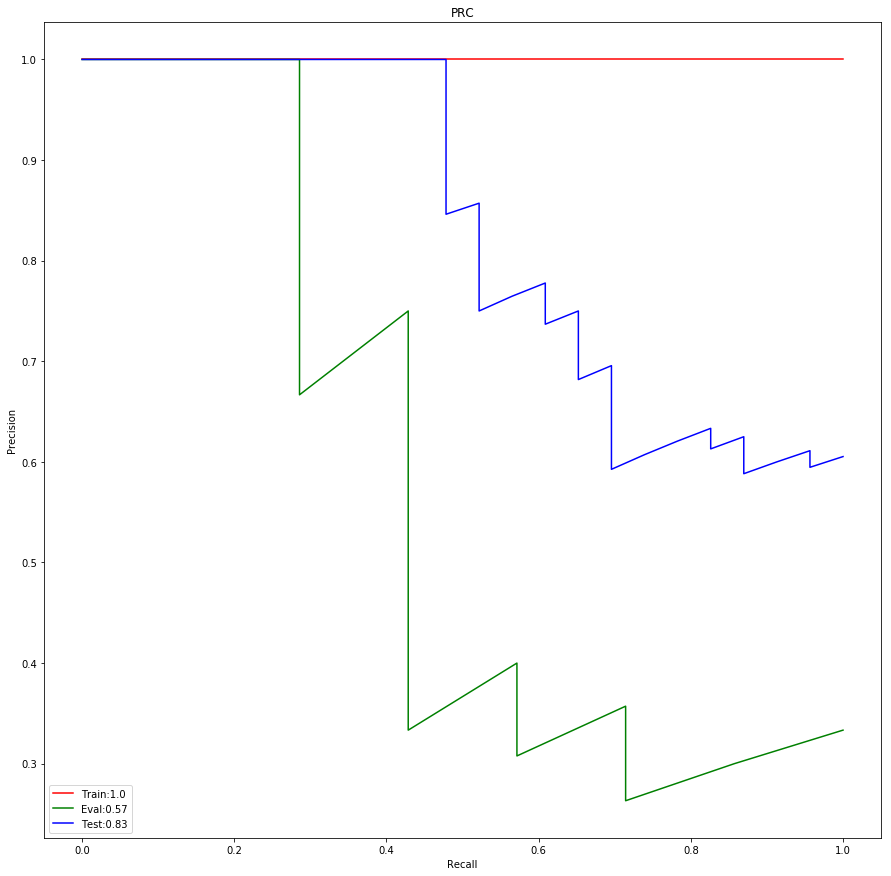

In [67]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.5,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.5,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.5,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

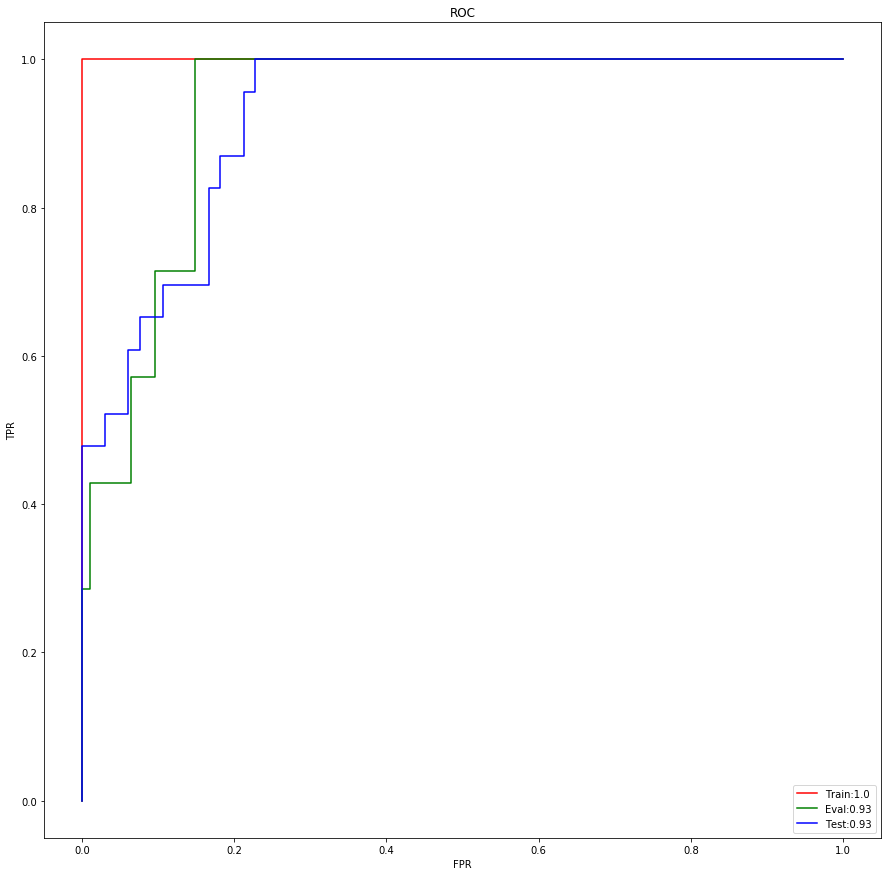

In [68]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.5,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.5,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.5,test_pred)

auroc_train=roc_auc_score(train_y>=0.5,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.5,eval_pred)
auroc_test=roc_auc_score(test_y>=0.5,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

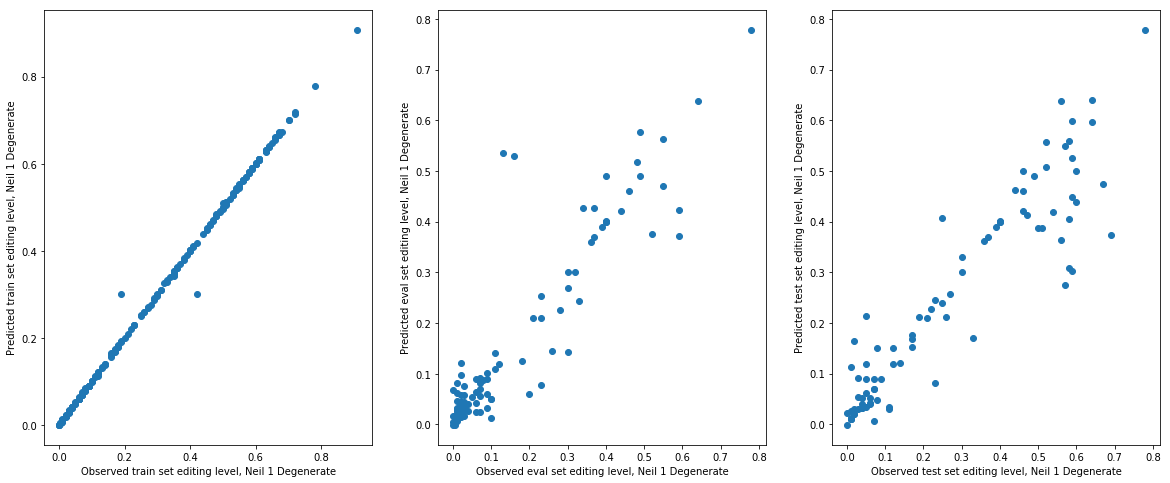

In [69]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

In [70]:
import plotnine
from plotnine import *
test_df=pd.DataFrame({'Observed':test_y,
                     'Predicted':test_pred,
                     'Dataset':'NEIL1_COMP'})

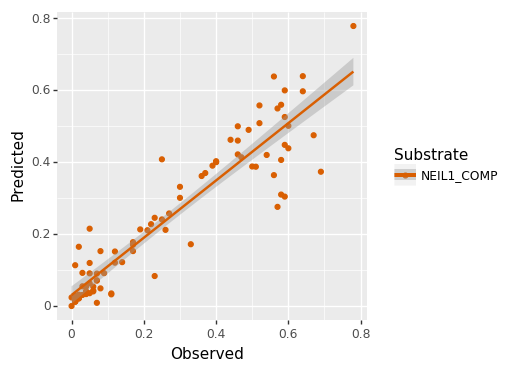

<ggplot: (8779335879481)>


/users/annashch/miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:708: UserWarning:

Saving 4 x 4 in image.

/users/annashch/miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:709: UserWarning:

Filename: NEIL1.comp.substrate.svg



In [71]:
plotnine.options.figure_size = (4, 4)

p=(ggplot(test_df, aes('Observed', 'Predicted', color='factor(Dataset)'))
 + geom_point()
 + stat_smooth(method='lm')
 + scale_color_manual(values=['#d95f02'],name="Substrate"))
print(p)
ggsave(plot=p, filename='NEIL1.comp.substrate.svg',width=4,height=4,units='in')


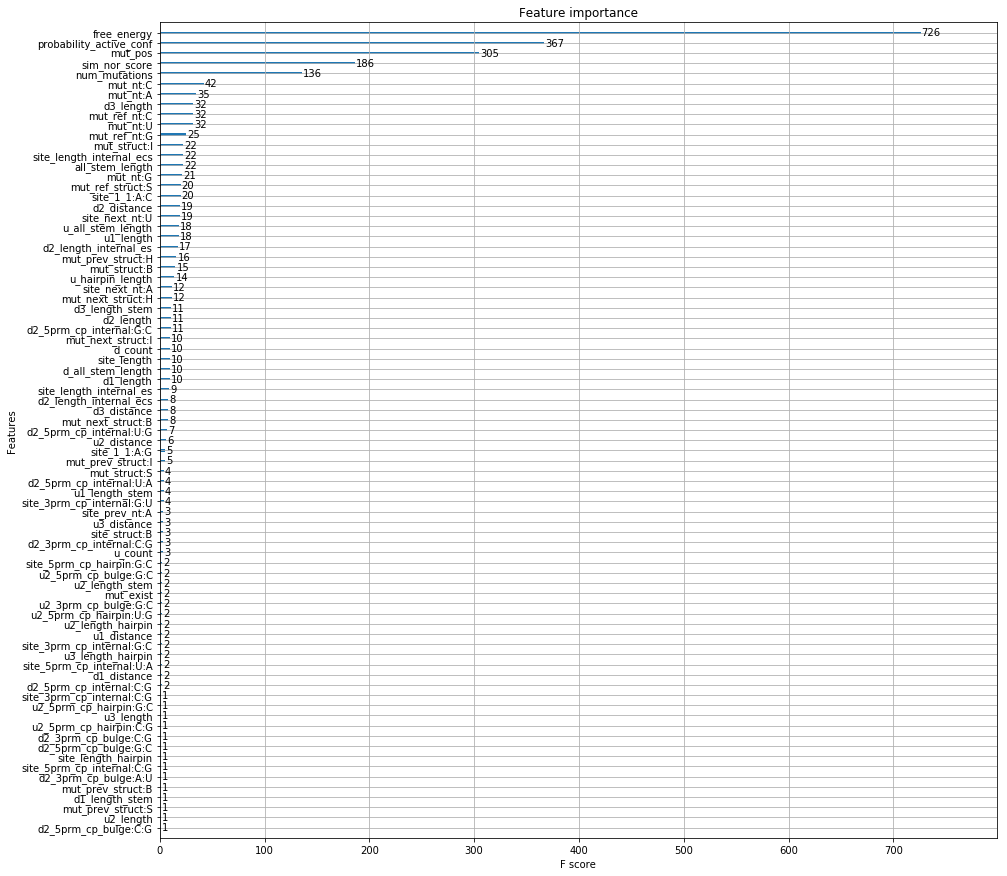

In [72]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

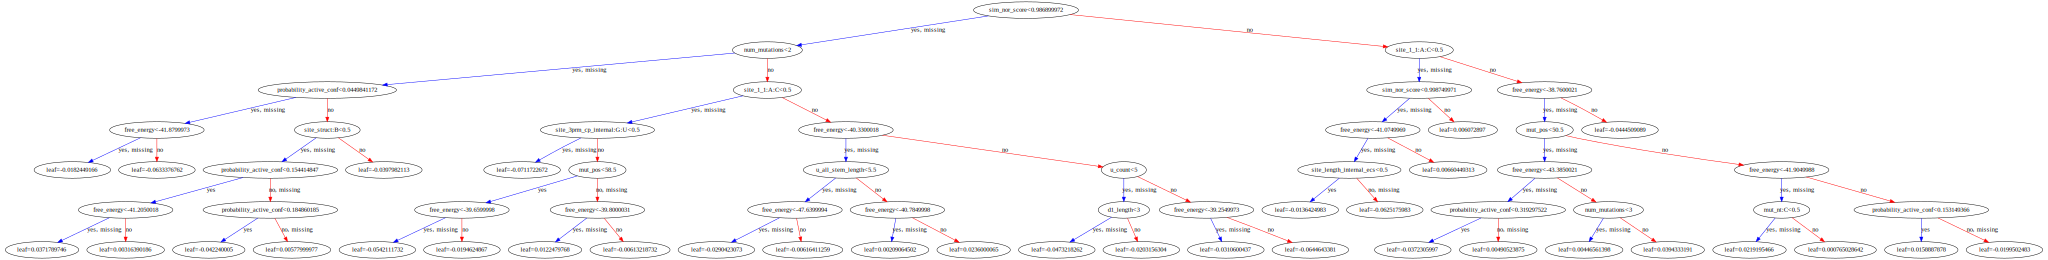

In [73]:
xgboost.to_graphviz(bst, num_trees=2)


In [74]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(89, 154)

In [75]:
shap.force_plot

<function shap.plots.force.force_plot(base_value, shap_values, features=None, feature_names=None, out_names=None, link='identity', plot_cmap='RdBu', matplotlib=False, show=True, figsize=(20, 3), ordering_keys=None, ordering_keys_time_format=None)>

In [76]:
test_X.iloc[6,:].shape

(154,)

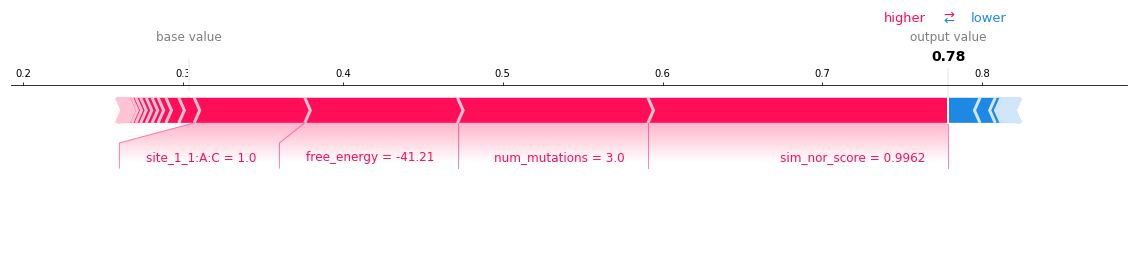

In [79]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
# visualize prediction for isoform with the highest editing level 
shap.initjs()
matplotlib=True
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:],matplotlib=True,show=False)
plt.savefig("NEIL1.comp.visualize_prediction.highest.svg", format='svg', width=7, height=1, dpi=300, bbox_inches="tight")

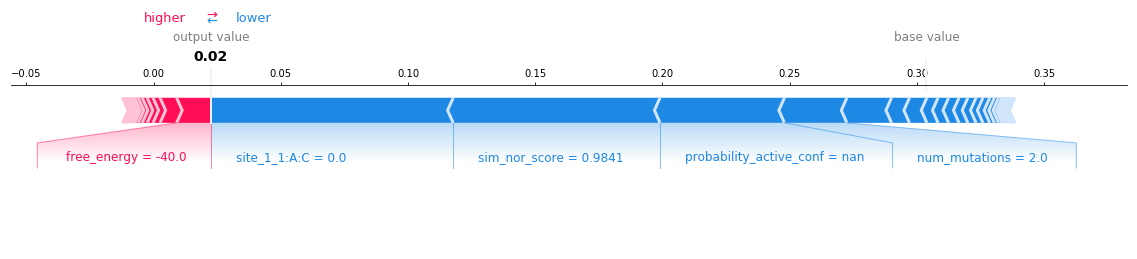

In [80]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
matplotlib=True
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:],matplotlib=True,show=False)
plt.savefig("NEIL1.comp.visualize_prediction.lowest.svg", format='svg', width=7, height=1, dpi=300, bbox_inches="tight")

In [81]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

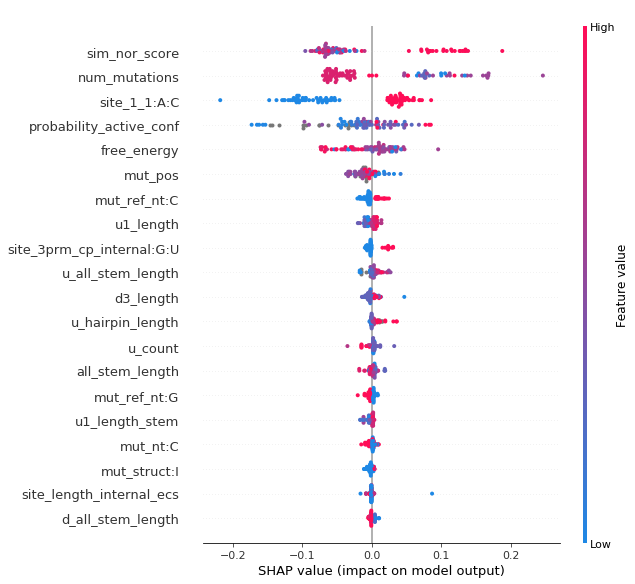

In [82]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X,show=False)
plt.savefig("NEIL1.comp.shap.svg", format='svg',width=20,height=10,dpi=300,bbox_inches="tight")


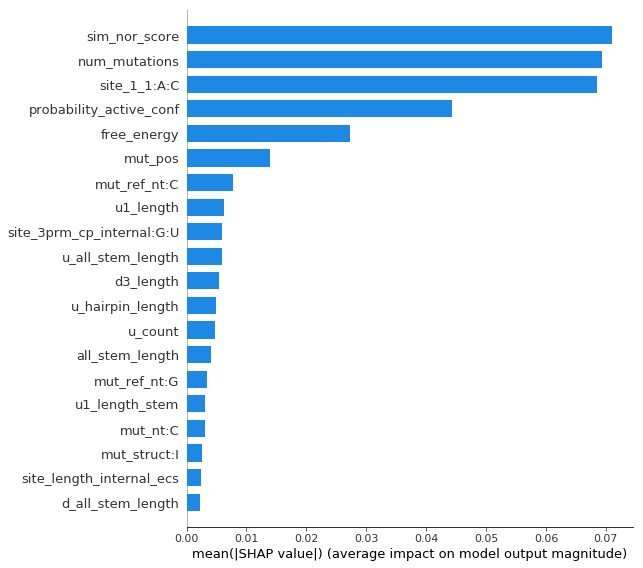

In [83]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [84]:
mean_abs_shap_vals=np.mean(abs(shap_values),axis=0)
features=test_X.columns
shap_dict=pd.DataFrame({'feature':features,
          'mean_abs_shap':mean_abs_shap_vals})
shap_dict.to_csv("NEIL1_comp_shap_mean_abs.txt",index=False,sep='\t')

In [85]:
shap_dict

feature  mean_abs_shap
0                free_energy       0.027293
1              sim_nor_score       0.070965
2    probability_active_conf       0.044341
3              num_mutations       0.069319
4                  mut_exist       0.000036
5             mut_type:indel       0.000000
6          mut_type:mismatch       0.000000
7                mut_type:wt       0.000000
8                    mut_pos       0.013907
9              mut_site_dist       0.000000
10              mut_ref_nt:C       0.007667
11              mut_ref_nt:G       0.003420
12                  mut_nt:A       0.001660
13                  mut_nt:C       0.003047
14                  mut_nt:G       0.001279
15                  mut_nt:U       0.001359
16              mut_struct:B       0.000297
17              mut_struct:I       0.002635
18              mut_struct:S       0.000100
19          mut_ref_struct:S       0.001205
20         mut_prev_struct:B       0.000358
21         mut_prev_struct:H       0.000359
22         mut_prev_struct:I       0.000982
23         mut_prev_struct:S       0.000346
24         mut_next_struct:B       0.000509
25         mut_next_struct:H       0.001828
26         mut_next_struct:I       0.000192
27         mut_next_struct:S       0.000000
28          mut_same_as_site       0.000000
29           all_stem_length       0.004073
..                       ...            ...
124                d2_length       0.000314
125           d2_length_stem       0.000000
126          d2_length_bulge       0.000000
127    d2_length_internal_es       0.001336
128   d2_length_internal_ecs       0.000254
129     d2_5prm_cp_bulge:C:G       0.000529
130     d2_5prm_cp_bulge:G:C       0.000004
131     d2_3prm_cp_bulge:A:U       0.000274
132     d2_3prm_cp_bulge:C:G       0.000044
133  d2_5prm_cp_internal:C:G       0.000834
134  d2_5prm_cp_internal:G:C       0.001204
135  d2_5prm_cp_internal:U:A       0.000749
136  d2_5prm_cp_internal:U:G       0.000128
137  d2_3prm_cp_internal:C:G       0.000154
138  d2_3prm_cp_internal:G:C       0.000000
139  d2_3prm_cp_internal:U:A       0.000000
140  d2_3prm_cp_internal:U:G       0.000000
141              d3_distance       0.000236
142              d3_struct:B       0.000000
143              d3_struct:I       0.000000
144              d3_struct:S       0.000000
145                d3_length       0.005484
146           d3_length_stem       0.000575
147          d3_length_bulge       0.000000
148    d3_length_internal_es       0.000000
149   d3_length_internal_ecs       0.000000
150     d3_5prm_cp_bulge:G:C       0.000000
151     d3_3prm_cp_bulge:C:G       0.000000
152  d3_5prm_cp_internal:G:C       0.000000
153  d3_3prm_cp_internal:G:C       0.000000

[154 rows x 2 columns]

In [86]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(89, 154, 154)

In [87]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [88]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [89]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)


## Computational Dataset: Feature Subsets<a name='4'>
<a href=#outline>Home</a>

In [90]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

['site_prev_nt*', 'site_next_nt*']


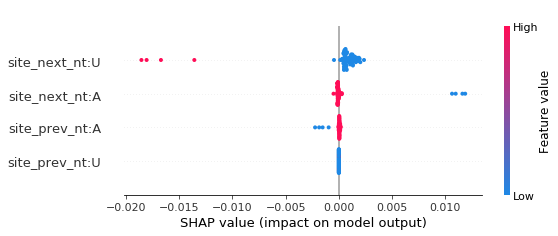

Contribution/Total:0.0061626406
['free_energy*', 'sim_nor_score*', 'probability_active_conf*']


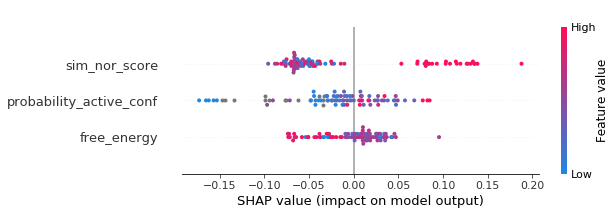

Contribution/Total:0.367154
['u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*']


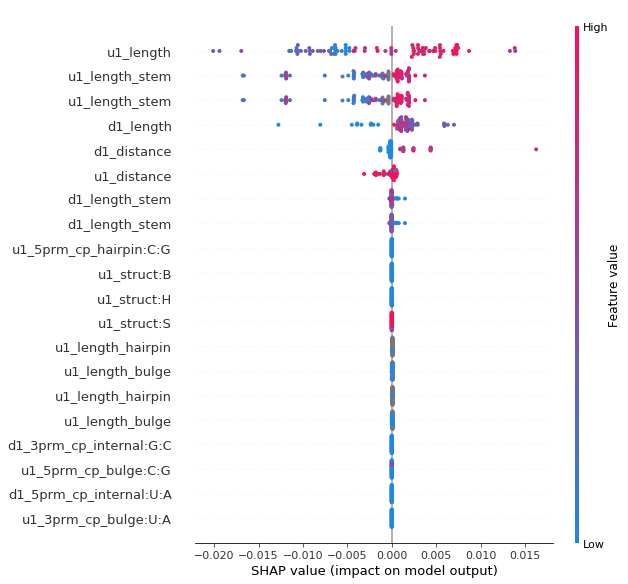

Contribution/Total:0.041891098
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


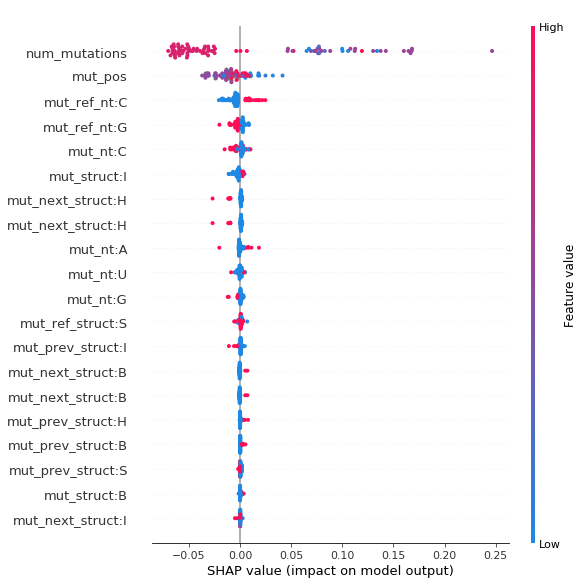

Contribution/Total:0.29094082
['site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


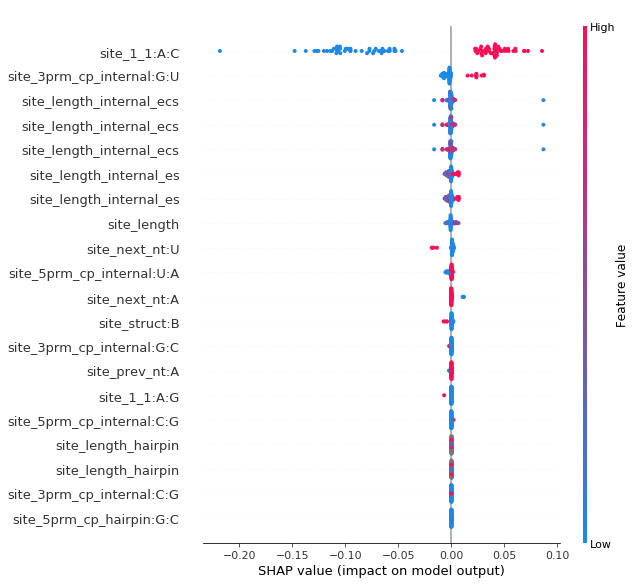

Contribution/Total:0.23475125
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*']


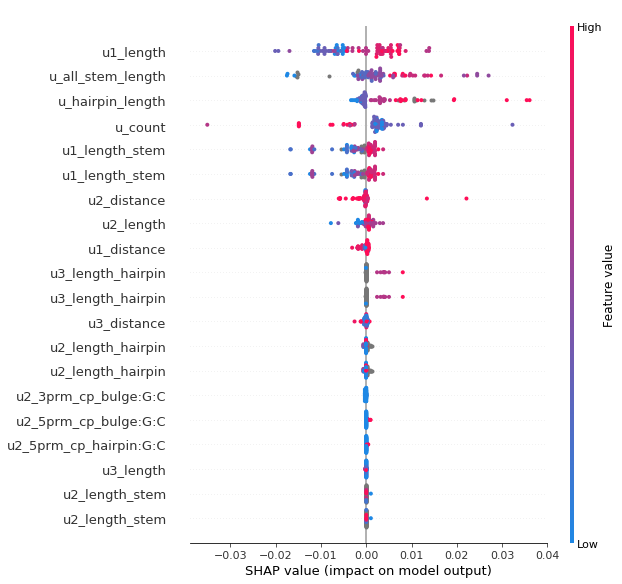

Contribution/Total:0.08372663
['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_internal_es*', 'd2_length_internal_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_internal*', 'd2_3prm_cp_internal*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_internal_es*', 'd3_length_internal_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_internal*', 'd3_3prm_cp_internal*']


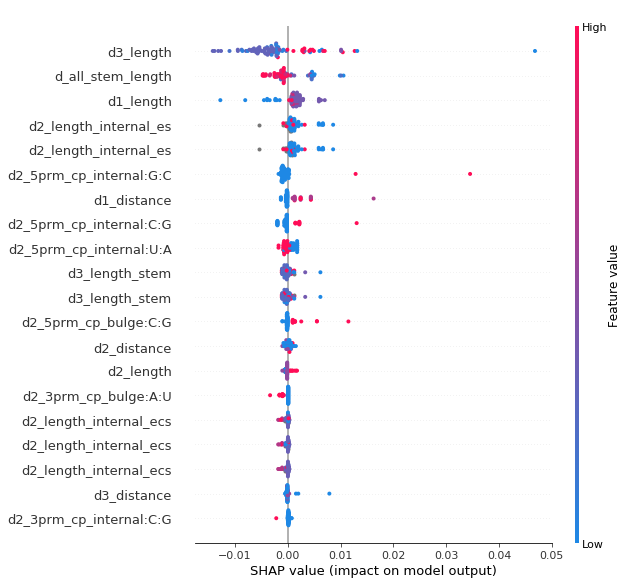

Contribution/Total:0.052894704
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*'

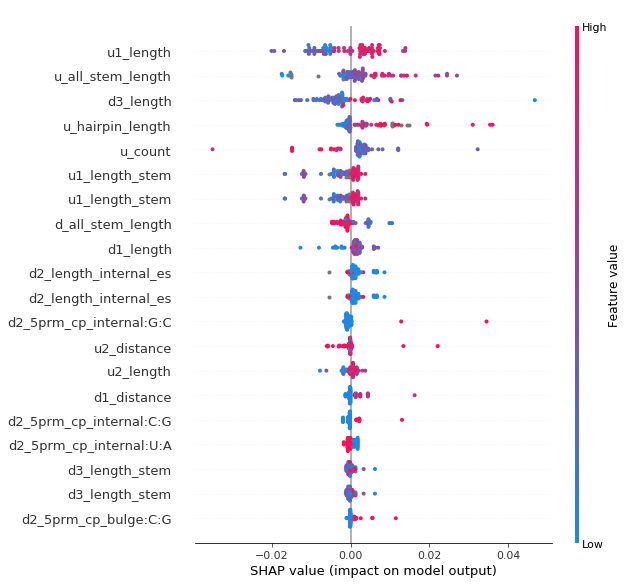

Contribution/Total:0.13662134
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


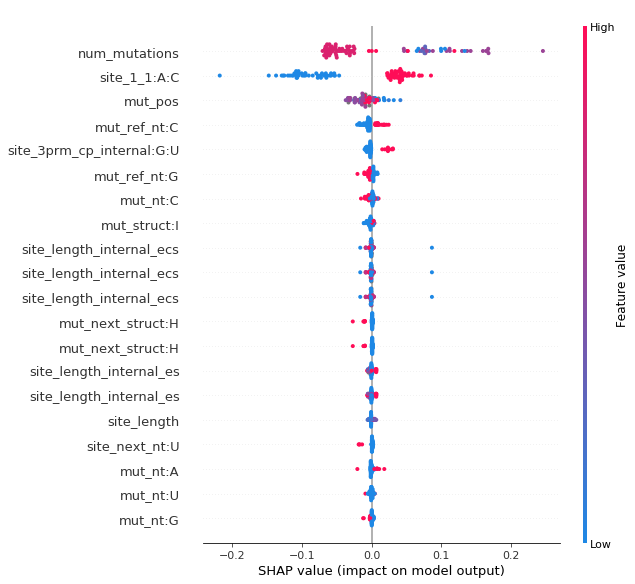

Contribution/Total:0.5256921
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_s

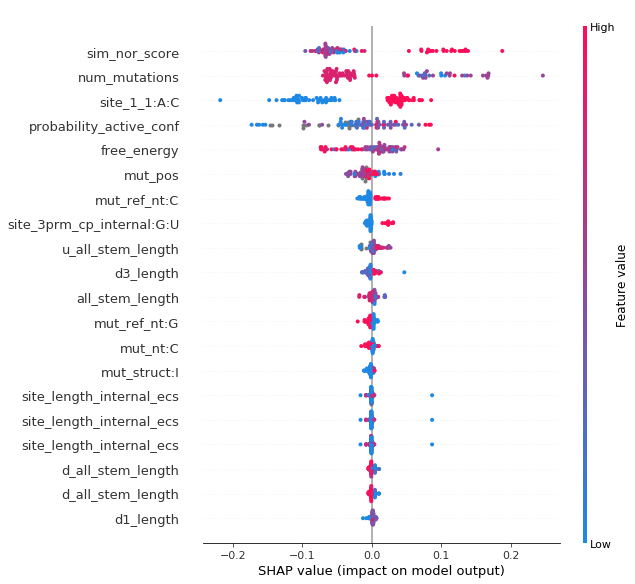

Contribution/Total:0.9771575
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 

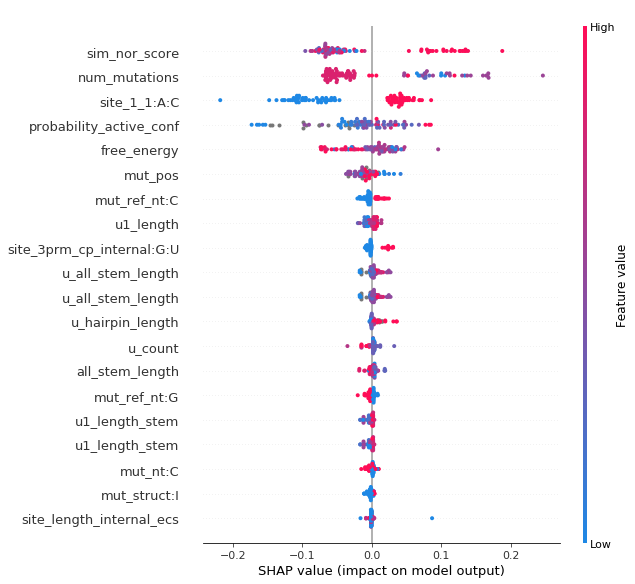

Contribution/Total:1.0079894
['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


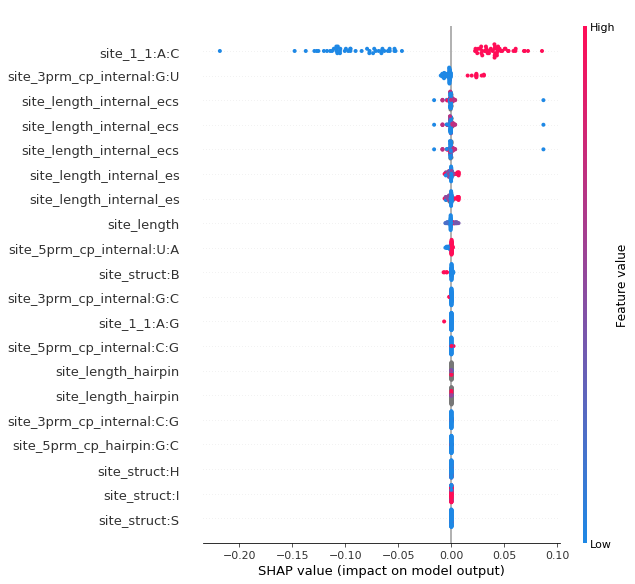

Contribution/Total:0.22858861
['site_prev_nt*', 'site_next_nt*']


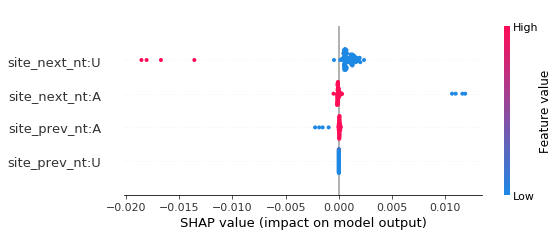

Contribution/Total:0.0061626406
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


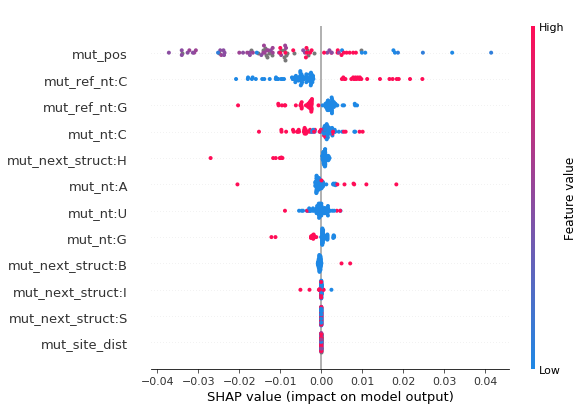

Contribution/Total:0.08977721
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'site_prev_nt*', 'site_next_nt*']


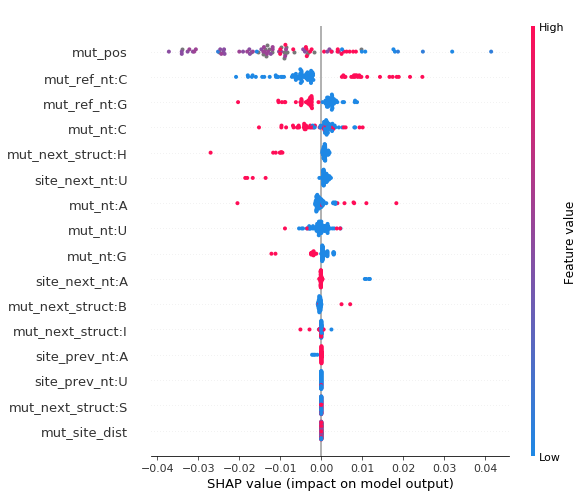

Contribution/Total:0.09593986
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_c

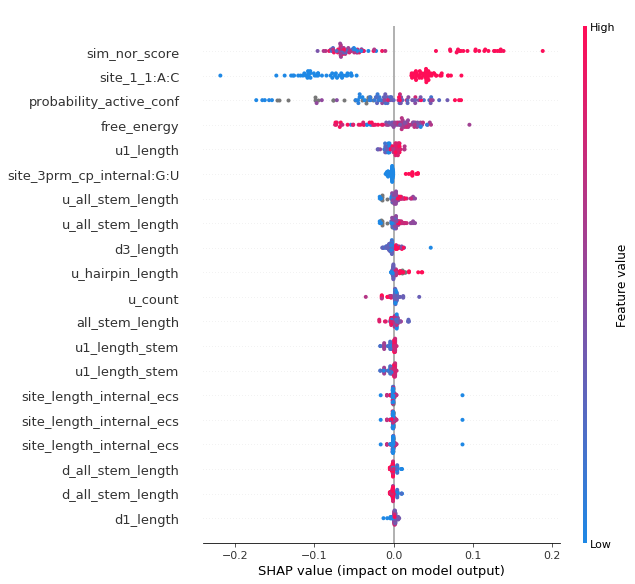

Contribution/Total:0.7699433
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*']


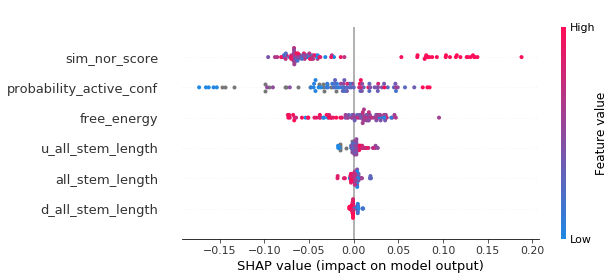

Contribution/Total:0.39857072


In [98]:
from feature_subsets import * 
subset_names=["sub_site_seq","biophysical","u1_d1","mut","site","u","d","u_d","mut_site","no_up","no_down","site_struct","site_seq","mut_seq","mut_seq_site","no_mut","overall_structure"]
subset_contribs=[]
for subset in [sub_site_seq,biophysical, u1_d1,mut,site,u,d,u_d,mut_site,no_up,no_down,site_struct,site_seq,mut_seq,mut_seq_site,no_mut,overall_structure]: 
  print(subset)
  cur_features=filter_features(shap_values,subset)
  cur_feature_shap=shap_values[cur_features].values 
  cur_feature_data_X=test_X[cur_features]
  shap.summary_plot(cur_feature_shap, cur_feature_data_X)#,sort=False,max_display=50)
  contrib=shap_contribs_subgroup(shap_values,subset)
  subset_contribs.append(contrib)
  print("Contribution/Total:"+str(contrib))

In [99]:
subset_contrib_df=pd.DataFrame({'Subset':subset_names,
                               'Contribution':[100*i for i in subset_contribs]})

In [100]:
subset_contrib_df=subset_contrib_df.sort_values(by=['Contribution'],ascending=False)
subset_contrib_df.reset_index(inplace=True, drop=True) 

In [101]:
from pandas.api.types import CategoricalDtype


In [102]:
subset_cat = CategoricalDtype(categories=list(subset_contrib_df['Subset']), ordered=True)

# Cast the existing categories into the new category. Due to a bug in pandas
# we need to do this via a string.
subset_contrib_df['Subset_Cat'] = subset_contrib_df['Subset'].astype(str).astype(subset_cat)


In [103]:
subset_contrib_df

Subset  Contribution         Subset_Cat
0             no_down    100.798941            no_down
1               no_up     97.715747              no_up
2              no_mut     76.994330             no_mut
3            mut_site     52.569211           mut_site
4   overall_structure     39.857072  overall_structure
5         biophysical     36.715400        biophysical
6                 mut     29.094082                mut
7                site     23.475125               site
8         site_struct     22.858861        site_struct
9                 u_d     13.662134                u_d
10       mut_seq_site      9.593986       mut_seq_site
11            mut_seq      8.977721            mut_seq
12                  u      8.372663                  u
13                  d      5.289470                  d
14              u1_d1      4.189110              u1_d1
15           site_seq      0.616264           site_seq
16       sub_site_seq      0.616264       sub_site_seq

/users/annashch/miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:708: UserWarning:

Saving 5 x 4 in image.

/users/annashch/miniconda3/lib/python3.6/site-packages/plotnine/ggplot.py:709: UserWarning:

Filename: NEIL1.comp.subset.importance.svg



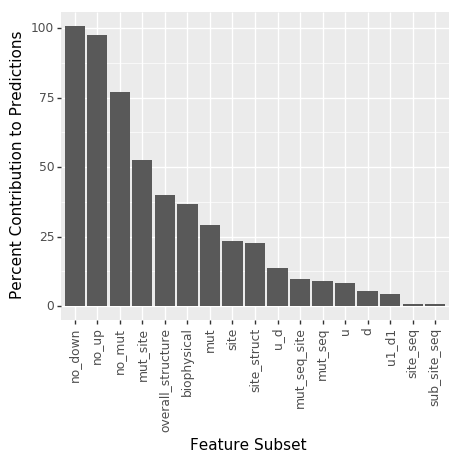

<ggplot: (8779365408832)>

In [104]:
p=(ggplot(subset_contrib_df, aes('Subset_Cat', 'Contribution'))
 + geom_bar(stat='identity')
 + xlab("Feature Subset")
 + ylab("Percent Contribution to Predictions")
 + theme(axis_text_x=element_text(angle=90))
)
ggsave(plot=p, filename='NEIL1.comp.subset.importance.svg',width=5,height=4,units='in')
p

## No "mut" features

In [ ]:
## Read in the data 
import feature_subsets
import pandas as pd 
data=pd.read_csv("../xin_feature_matrices/neil1_degenerate_computational.features.csv",header=0,sep=',',index_col=0)
#drop all mut features
cur_features=filter_features(data,feature_subsets.mut)
cur_features.remove('mut_pos')
data=data.drop(cur_features,axis=1)
data.head


In [ ]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [ ]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

In [ ]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [ ]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [ ]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
to_drop.append("mut_pos")
print("\n".join(to_drop))

In [ ]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [ ]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [ ]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


In [ ]:
## format matrixes for xgboost 
import xgboost
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [ ]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [ ]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [ ]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

In [ ]:
# save to binary file for faster loading
bst.save_model('neil1.computational.model')
# save model to text file 
bst.dump_model('neil1.computational.raw.txt')


In [ ]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [ ]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

In [ ]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


In [ ]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

In [ ]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


In [ ]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.5,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.5,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.5,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

In [ ]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.5,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.5,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.5,test_pred)

auroc_train=roc_auc_score(train_y>=0.5,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.5,eval_pred)
auroc_test=roc_auc_score(test_y>=0.5,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

In [ ]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

In [ ]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

In [ ]:
xgboost.to_graphviz(bst, num_trees=2)


In [ ]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

In [ ]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [ ]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [ ]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

In [ ]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


In [ ]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [ ]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

In [ ]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [ ]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [ ]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)
